# TD 11 : Calcul numérique, dichotomie et Cython

- [Exercice 1 : application d'un filtre](#exo1)
- [Exercice 2 : plus grande séquence croissante](#exo2)
    - [Solution simple](#n2)
    - [Solution simple améliorée](#n22)
    - [Un peu plus près de la solution optimale](#optln)
    - [Solution optimale](#opt)
- [Exercice 3 : python/C appliqué à une distance d'édition](#exo3)
    - [solution avec notebook](#cnb)
    - [solution sans notebook](#exo3nonb)

<h3 id="exo1">Exercice 1 : application d'un filtre</h3>

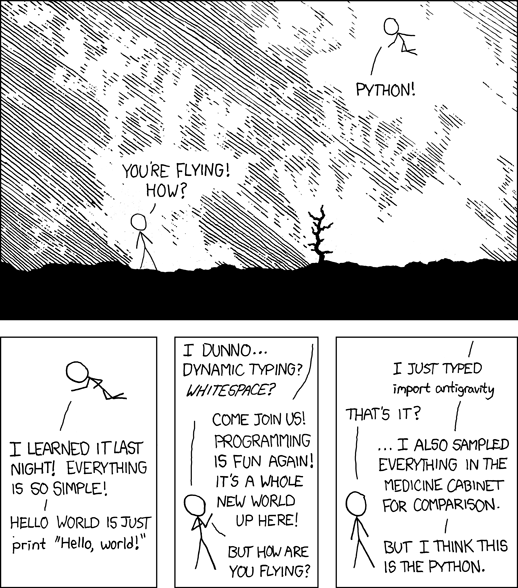

In [6]:
from pyquickhelper import noLOG
from pyensae import download_data
f = download_data("python.png", url="http://imgs.xkcd.com/comics/")
from IPython.display import Image
Image("python.png")

Mais avant de pouvoir faire des calculs dessus, il faut pouvoir convertir l'image en un tableau ``numpy`` avec la fonction [numpy.asarray](http://docs.scipy.org/doc/numpy/reference/generated/numpy.asarray.html).

In [3]:
import PIL
import PIL.Image
im = PIL.Image.open("python.png")
from PIL.ImageDraw import Draw
import numpy
tab = numpy.asarray(im)
tab.flags.writeable = True  # afin de pouvoir modifier l'image
"dimension",tab.shape, " type", type(tab[0,0])

('dimension', (588, 518), ' type', numpy.uint8)

Tout d'abord, nous allons utiliser la fonction [scipy.ndimage.filters.uniform_filter](http://scipy.org/) qui fait cela automatiquement.

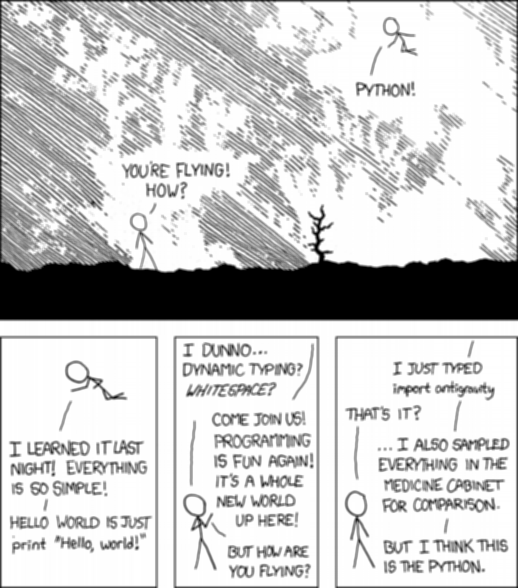

In [7]:
import scipy.ndimage.filters as filters
filtre = numpy.ones( (3,3) )
imgf   = filters.uniform_filter (tab, size=3)
imf = PIL.Image.fromarray(numpy.uint8(imgf))
imf.save("python_filtre.png")
Image("python_filtre.png")

Ensuite, voici une version s'appuyant sur le calcul matriciel. Lors du calcul du filtre, chaque pixel recevra 1/9 de la valeur du pixel placé juste avant sur la même ligne. C'est comme si on ajoutait à la matrice actuelle 8 fois la même matrice décalée d'un cran dans toutes les directions comme illustrée par la figure suivante.

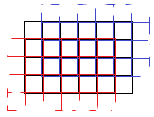

In [1]:
from pyquickhelper import NbImage
NbImage("td11_cor_grid.png")

Il faudra traiter différements les pixels du bord qui ont moins de voisins (lui même inclus) que les autres ce que reflète la matrice suivante :

In [21]:
nbv = numpy.ones ( tab.shape ) * 9
lx,ly = tab.shape
nbv [:,0] = 6
nbv [0,:] = 6
nbv [ :, ly-1] =  6
nbv [ lx-1,:] = 6
nbv[0,0] = nbv[0,ly-1] = nbv[lx-1,0] = nbv[lx-1,ly-1] = 4
nbv [:4,:3]

array([[ 4.,  6.,  6.],
       [ 6.,  9.,  9.],
       [ 6.,  9.,  9.],
       [ 6.,  9.,  9.]])

Il ne reste plus qu'à programmer le flitre :

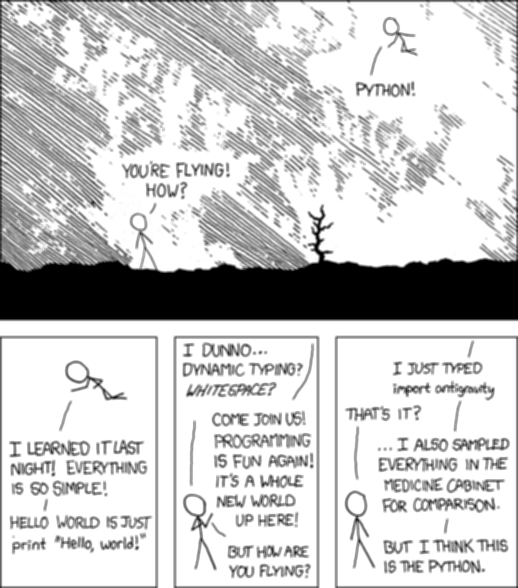

In [24]:
def filtre_sobel(image, filtre):

    nbv = numpy.ones ( image.shape ) * 9
    lx,ly = image.shape
    nbv [:,0] = 6
    nbv [0,:] = 6
    nbv [ :, ly-1] =  6
    nbv [ lx-1,:] = 6
    nbv[0,0] = nbv[0,ly-1] = nbv[lx-1,0] = nbv[lx-1,ly-1] = 4
    nbv [:4,:3]    
    
    res = numpy.zeros ( image.shape )
    for i in range(-1,2) :
        for j in range(-1,2) :
            coef = filtre [ i+1,j+1]
            mat = image [ max(i,0): min(lx+i,lx), max(j,0): min(ly+j,ly) ]
            mx,my = mat.shape
            i0,j0 = max(-i,0), max(-j,0)
            res [i0:i0+mx,j0:j0+my] += mat
    res /= nbv
    return res

res = filtre_sobel(tab, filtre)
im2 = PIL.Image.fromarray(numpy.uint8(res))
im2.save("python_filtre2.png")
Image("python_filtre2.png")

On programme maintenant la même fonction mais sans utiliser le calcul matriciel :

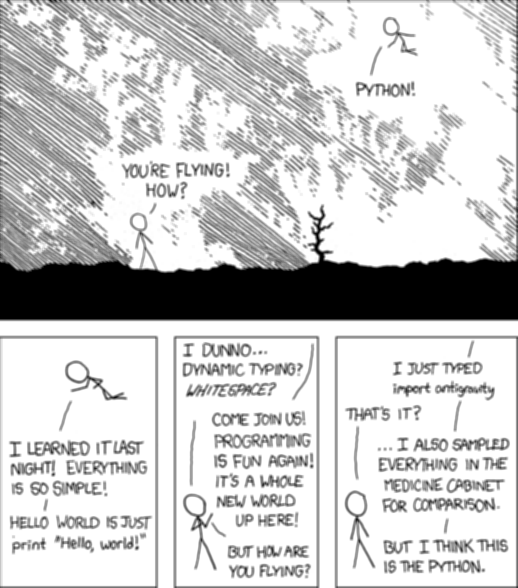

In [25]:
def filtre_sobel_python(image, filtre):
    res = numpy.zeros ( image.shape )
    for i in range(0, res.shape[0]):
        for j in range(0, res.shape[1]):
            nb = 0
            for k in range(-1,2) :
                for l in range(-1,2) :
                    if k+i > 0 and k+i < res.shape[0] and l+j > 0 and l+j < res.shape[1] :
                        res[i,j] += image[k+i, l+j]
                        nb += 1
            res[i,j] /= nb
    return res

res = filtre_sobel_python(tab, filtre)
im3 = PIL.Image.fromarray(numpy.uint8(res))
im3.save("python_filtre3.png")
Image("python_filtre3.png")

Il n'y pas vraiment besoin de mesurer le temps pour s'apercevoir que c'est beaucoup plus long.

<h3 id="exo2">Exercice 2 : plus grande séquence croissante</h3>

L'algorithme optimal est exposé en dernier, la correction propose un cheminement jusqu'à cette solution en introduisant au fur et à mesure les idées qui aboutissent à cette solution. A partir de la première solution, on élague peu à peu :

1. ce qu'il n'est pas nécessaire de faire car mathématiquement inutile et ne changeant pas la solution,
2. ce qu'il n'est pas nécessaire de conserver d'une itération à l'autre car cette information peut être reconstruite et qu'il coûte plus cher de la stocker que de la reconstruire.

$E[k]$, $E_k$ désignent l'élément d'indice $k$ de l'ensemble $E$. Sauf précision contraire, il est tenu compte de l'ordre de tous les éléments dans l'ensemble auxquels ils appartiennent.

<h4 id="n2">Solution simple</h4>

Prenons un tableau quelconque :

In [2]:
E = [10, 15, 7, 19, 2, 5, 7, 16, 3, 9, 15, 0, 1, 15, 6, 11, 0, 14, 7, 9]  
E

[10, 15, 7, 19, 2, 5, 7, 16, 3, 9, 15, 0, 1, 15, 6, 11, 0, 14, 7, 9]

Avant de passer à l'algorithme dichotomique, on va d'abord suivre un chemin plus facile et plus lent. Supposons qu'on connaît la meilleure séquence croissante de longueur $n :  s (1 \rightarrow n)$. 

On découpe cette séquence en deux $s(1 \rightarrow k)$ 
et $s(k+1 \rightarrow n)$. 
On est sûr que la séquence $s (1 \rightarrow k)$ est la plus grande séquence croissante incluant l'élément $s_k$. 
Dans le cas contraire, on aurait trouvé un moyen de fabriquer une plus longue séquence croissante sur $E$. Et c'est contradictoire avec l'hypothèse de départ. 

A chaque indice $k$, il existe une meilleure séquence $S[k]$ se terminant à la position $k$ : $E[k]$ est le dernier élément de la séquence. On suppose que toutes les meilleures séquences croissantes se terminant à la position $i$ pour $i \in [1:k]$. Comment calculer la meilleure séquence croissante pour la position $i+1$ ? D'après ce qui précède, il suffit de l'ajouter à toutes les séquences qui précèdent puis de choisir la meilleure. Une fois qu'on a obtenu toutes les meilleures séquences se terminant aux positions $i$, il suffit de prendre la plus longue.

In [4]:
def plus_grande_sequence_position_k ( E, k = None ) :
    if k is None :
        k = len(E)-1
    if k == 0 :
        return [  [ 0 ] ]
    else :
        S = plus_grande_sequence_position_k(E, k-1)
        
        best = [ ]
        for j,s in enumerate(S):
            if len(s) > len(best) and E[k] >= E [ s[-1] ] :
                best = s 
        best = best + [k]
        S.append(best)
        
        return S
                
def plus_grande_sequence(E):
    if len(E) == 0 : return E
    S = plus_grande_sequence_position_k(E)
    best = [ ]
    for s in S :
        if len(s) > len(best) :
            best = s
    return best
        
b = plus_grande_sequence(E)
"E",E,"indice:",b, "valeurs:", [ E[i] for i in b ]

('E',
 [10, 15, 7, 19, 2, 5, 7, 16, 3, 9, 15, 0, 1, 15, 6, 11, 0, 14, 7, 9],
 'indice:',
 [4, 5, 6, 9, 10, 13],
 'valeurs:',
 [2, 5, 7, 9, 15, 15])

Le coût de cet algorithme est en $O(n^2)$. L'énoncé de l'exercice suggère qu'on peut faire mieux en utilisant la dichotomie. En coupant l'ensemble $E$ en deux, $A=E (1 \rightarrow k)$ et $B=E(1 \rightarrow k+1)$, soit la plus grande séquence croissante est dans $A$, soit dans $B$, soit elle commence avant la position $k$ et se termine après. Les deux premiers cas sont très simples à traiter par récurrence. Le dernier l'est moins mais on sait deux choses : on cherche la séquence $s (a \rightarrow b)$ avec $a \leqslant k \leqslant b$ et la recherche de cette séquence doit avant un coût en $O(n)$ sinon le nouvel algorithme ne sera pas plus rapide que le précédent.

<h4 id="n22">Solution simple améliorée</h4>

Est-il nécessaire de garder l'historique des séquences ? Pour chaque position $k$, on conserve toute la meilleure séquence se terminant à la position $k$. Toutefois, il est possible de ne retenir que l'élément précédent : $P[E[k]]$ car la meilleure séquence $S[k]$ peut être décomposée en $S[ E[k] ] + [ E[k] ]$. Cette amélioration rentre dans la catégorie 2 : l'algorithme conserve une information non indispensable. 

La fonction est plus simple à implémenter de façon non récursive. Elle se sert de deux tableaux :

- $longueur[k]$ : conserve la longueur de la meilleure séquence se terminant à la position $k$
- $precedent[k]$ : conserve la position de l'élément précédent dans la meilleure séquence se terminant à la position $k$ (donc précédent $k$).

In [24]:
def plus_grande_sequence_2(E):
    if len(E) == 0 : return E
    
    precedent = [ -1 for e in E ]
    longueur  = [ 0 for e in E ]
    
    longueur [ 0 ] = 1
    for k in range(1,len(E)) :
        
        bestL = 1
        bestP = -1
        
        for j in range(0,k) :
            if E[k] >= E [ j ] and longueur[j]+1 > bestL :
                bestL = longueur [j]+1
                bestP = j
                
        precedent[k] = bestP
        longueur[k] = bestL
        
    # on récupère la longueur de la plus grande séquence
    maxiL = 0
    for i,l in enumerate(longueur) :
        if l > longueur[maxiL] :
            maxiL = i
            
    # on récupère la plus grande séquence
    seq = [ maxiL ]
    while precedent[ seq[-1] ] != -1 :
        p = precedent[seq[-1]]
        seq.append(p)
        
    seq.reverse()
    return seq
        
E = [10, 15, 7, 19, 2, 5, 7, 16, 3, 9, 15, 0, 1, 15, 6, 11, 0, 14, 7, 9]  
b = plus_grande_sequence_2(E)
"E",E,"indice:",b, "valeurs:", [ E[i] for i in b ]

('E',
 [10, 15, 7, 19, 2, 5, 7, 16, 3, 9, 15, 0, 1, 15, 6, 11, 0, 14, 7, 9],
 'indice:',
 [4, 5, 6, 9, 10, 13],
 'valeurs:',
 [2, 5, 7, 9, 15, 15])

On compare les coûts. La seconde fonction est un peu plus rapide à un facteur multiplicatif près. Le coût des deux fonctions est $O(n^2)$.

In [14]:
import random
for n in (20,50,100,200) :
    E = [ random.randint(0,n) for i in range(n) ]
    print("n=",n)
    %timeit plus_grande_sequence(E)
    %timeit plus_grande_sequence_2(E)

n= 20
10000 loops, best of 3: 108 µs per loop


10000 loops, best of 3: 70.1 µs per loop


n= 50
1000 loops, best of 3: 542 µs per loop


1000 loops, best of 3: 381 µs per loop


n= 100
1000 loops, best of 3: 1.9 ms per loop


1000 loops, best of 3: 1.3 ms per loop


n= 200
100 loops, best of 3: 7.31 ms per loop


100 loops, best of 3: 4.79 ms per loop

<h4 id="optln">Un peu plus près de la solution optimale</h4>

La fonction précédente se termine par deux boucles. La première détermine la longueur de la plus longue séquence, la seconde reconstruit la séquence. Pour chaque $k$, on conserve la meilleure séquence croissante se terminant à la position $k$. Mais supposons que nous sommes à l'itération $l$, et pour les positions $j < k < l$, et que les deux meilleures séquences se terminant aux positions $k$ et $j$ ont même longueur et que $E[k] < E[j]$, est-il vraiment nécessaire de conserver une seconde séquence aussi longue mais dont le dernier élément est plus grand ?

$$ \begin{array}{|c|c|c|c|c|c|c|} \hline & & & j & k & ... & l\\ \hline S_j &  2 & 3 & 5 & &&   \\ \hline S_k &  2 & 3 &   & 4 && \\ \hline \end{array} $$

La réponse est évidemment non. Par extension, à la position $l$, on peut classer toutes les séquences se terminant avant :

- par longueur décroissante
- par dernier élément croissant

Pour chaque longueur, on va conserver le plus petit dernier élément possible parmi toutes les séquences de cette longueur. L'optimisation est deux types : type 1 car l'algorithme est différent (le coût est plus faible), type 2 car il stocke moins d'information.

In [2]:
def plus_grande_sequence_2L(E):
    if len(E) == 0 : return E
    
    dernier   = [ 0 ]
    precedent = [ -1 for e in E ]
    
    for k in range(1,len(E)) :
        if E[k] >= E [ dernier [-1] ] :
            # on ajoute à la dernière séquence
            precedent[k] = dernier[-1]
            dernier.append( k )
        else :
            # on s'en sert pour améliorer une séquence existante
            for j in range(len(dernier)-1,-1,-1) :
                if E[k] < E [ dernier[j] ] :
                    if precedent [ dernier[j] ] == -1:
                        dernier [j] = k
                    elif E[k] >= E [ dernier[j-1] ] :
                        if j == 0: stop
                        precedent[ k ] = dernier[j-1] 
                            # ce n'est pas exactement precedent [ dernier[j] ], 
                            # mais cette valeur est admissible par construction
                        dernier [j] = k
                        break  # car il ne sert à rien d'aller plus loin
                
        
    # on récupère la plus grande séquence
    seq = [ dernier[-1] ]
    while precedent[ seq[-1] ] != -1 :
        p = precedent[seq[-1]]
        seq.append(p)
        
    seq.reverse()
    return seq
        
E = [10, 15, 7, 19, 2, 5, 7, 16, 3, 9, 15, 0, 1, 15, 6, 11, 0, 14, 7, 9]  
b = plus_grande_sequence_2L(E)
"E",E,"indice:",b, "valeurs:", [ E[i] for i in b ]

('E',
 [10, 15, 7, 19, 2, 5, 7, 16, 3, 9, 15, 0, 1, 15, 6, 11, 0, 14, 7, 9],
 'indice:',
 [4, 5, 6, 9, 15, 17],
 'valeurs:',
 [2, 5, 7, 9, 11, 14])

On compare les coûts. La seconde fonction est un peu plus rapide à un facteur multiplicatif près. Le coût de la première fonction est en $O(n^2)$. La seconde est en $O(nL)$ où $L$ est la longueur de la plus longueur séquence. On majore ce coût par $O(n^2)$ mais dans les faits, c'est plus court.

In [27]:
import random
for n in (20,50,100,200) :
    E = [ random.randint(0,n) for i in range(n) ]
    %timeit plus_grande_sequence_2(E)
    %timeit plus_grande_sequence_2L(E)

10000 loops, best of 3: 69.4 µs per loop
10000 loops, best of 3: 53.7 µs per loop


1000 loops, best of 3: 336 µs per loop


10000 loops, best of 3: 131 µs per loop


1000 loops, best of 3: 1.24 ms per loop


1000 loops, best of 3: 328 µs per loop


100 loops, best of 3: 4.9 ms per loop


1000 loops, best of 3: 895 µs per loop

<h4 id="opt">Solution optimale</h4>

Enfin, la solution proposée sur la page [wikipedia](http://en.wikipedia.org/wiki/Longest_increasing_subsequence#Efficient_algorithms). Elle consiste simplement à remplacer la boucle imbriquée par une recherhce dichotomique. En effet, on cherche le premier élément plus petit qu'un autre dans un tableau trié. Cela peut être aisément remplacé par une recherche dichotomique. Les paragraphes qui suivent reprennent l'explication depuis le début avec les notations de l'article [wikipedia](http://en.wikipedia.org/wiki/Longest_increasing_subsequence#Efficient_algorithms).

L'idée consiste à parcourir le tableau de gauche à droite en conservant à chaque itération des séquences optimales de longueur $1$ à $L$ en s'assurant que chaque séquence se termine par le plus petit entier possible.

L'implémentation s'appuie sur un tableau $M _ {1 \rightarrow n}$. La variable $L$ mémorise la longueur de la plus grande séquence connue jusque là. A l'itération $i$, $M[L]$ contient l'indice du dernier élément de la meilleure séquence croissante de longueur $L$ dans l'ensemble $E (1 \rightarrow i)$. $M[k]$ pour $1 \leqslant i \leqslant i$ contient l'indice du dernier élément d'une séquence de $k$ nombre compris entre les indices $1$ et $i$.

A chaque itération $i+1$, on met à jour le tableau $M$ en considérant l'élément $E[i+1]$. Tout d'abord, si $E[i+1] \geqslant E[ M[L]]$, cela veut dire qu'on peut ajouter l'élément $E[i+1]$ à la plus grande séquence connue, elle sera nécessairement la plus grande. Si maintenant $E[i+1] < E[ M[L]]$, il n'y aura pas de meilleure séquence. Pour autant, cet élément remplacera le dernier élément d'une séquence de longueur moindre s'il est plus petit. On peut aisément comprendre cela : si deux séquences ont même longueur, celle se terminant par le plus petit élément a plus de chance de s'agrandir par la suite.

L'algorithme repose sur une propriété du tableau $M$ : la suite $E[M[i]]$ est croissante entre $1$ et $L$. On peut dire cela autrement : il existe une séquence de longueur $L-1$ dont le dernier élément est nécessaire plus petit que le dernier élément de la meilleure séquence de longueur $L$. Il suffit que prend les $L-1$ premiers éléments de la meilleure séquence de longueur $L$.

In [28]:
def plus_grande_sequence_wikipedia(E):
    P = [ -1 for _ in E ]
    M = [ -1 for _ in E ]

    L = 0
    for i in range (0,len(E)):
        lo = 1
        hi = L
        while lo <= hi:
            mid = (lo+hi)//2
            if E[M[mid]] < E[i]:
                lo = mid+1
            else:
                hi = mid-1

        newL = lo
        P[i] = M[newL-1]

        if newL > L:
            M[newL] = i
            L = newL
        elif E[i] < E[M[newL]]:
            M[newL] = i

    S = [ -1 for i in range(L) ]
    k = M[L]
    for i in range(L-1,-1,-1) :
        S[i] = k
        k = P[k]

    return S

E = [10, 15, 7, 19, 2, 5, 7, 16, 3, 9, 15, 0, 1, 15, 6, 11, 0, 14, 7, 9]  
b = plus_grande_sequence_wikipedia(E)
"E",E,"...","indice:",b, "valeurs:", [ E[i] for i in b ]

('E',
 [10, 15, 7, 19, 2, 5, 7, 16, 3, 9, 15, 0, 1, 15, 6, 11, 0, 14, 7, 9],
 '...',
 'indice:',
 [4, 5, 6, 9, 15, 17],
 'valeurs:',
 [2, 5, 7, 9, 11, 14])

On compare avec la version précédente et on vérifie qu'elle est plus rapide.

In [29]:
import random
for n in (20,50,100,200) :
    E = [ random.randint(0,n) for i in range(n) ]
    print("n=",n)
    %timeit plus_grande_sequence_2L(E)
    %timeit plus_grande_sequence_wikipedia(E)

n= 20
10000 loops, best of 3: 48.4 µs per loop


10000 loops, best of 3: 42.5 µs per loop


n= 50
10000 loops, best of 3: 132 µs per loop


10000 loops, best of 3: 114 µs per loop


n= 100
1000 loops, best of 3: 314 µs per loop


1000 loops, best of 3: 245 µs per loop


n= 200
1000 loops, best of 3: 1.01 ms per loop


1000 loops, best of 3: 566 µs per loop

<h3 id="exo3">Exercice 3 : python/C appliqué à une distance d'édition</h3>

On reprend la fonction donnée dans l'énoncé.

In [1]:
def distance_edition(mot1, mot2):
    dist = { (-1,-1): 0 }
    for i,c in enumerate(mot1) :
        dist[i,-1] = dist[i-1,-1] + 1
        dist[-1,i] = dist[-1,i-1] + 1
        for j,d in enumerate(mot2) :
            opt = [ ]
            if (i-1,j) in dist : 
                x = dist[i-1,j] + 1
                opt.append(x)
            if (i,j-1) in dist : 
                x = dist[i,j-1] + 1
                opt.append(x)
            if (i-1,j-1) in dist :
                x = dist[i-1,j-1] + (1 if c != d else 0)
                opt.append(x)
            dist[i,j] = min(opt)
    return dist[len(mot1)-1,len(mot2)-1]

%timeit distance_edition("idstzance","distances")

1000 loops, best of 3: 230 µs per loop


<h4 id="cnb">solution avec notebook</h4>

Les préliminaires :

In [ ]:
%load_ext cythonmagic

Puis :

In [5]:
%%cython
cimport cython

def cidistance_edition(str mot1, str mot2):
    cdef int dist [500][500]
    cdef int cost, c 
    cdef int l1 = len(mot1)
    cdef int l2 = len(mot2)
    
    dist[0][0] = 0
    for i in range(l1):
        dist[i+1][0] = dist[i][0] + 1
        dist[0][i+1] = dist[0][i] + 1
        for j in range(l2):
            cost = dist[i][j+1] + 1
            c    = dist[i+1][j] + 1
            if c < cost : cost = c
            c = dist[i][j]
            if mot1[i] != mot2[j] : c += 1
            if c < cost : cost = c
            dist[i+1][j+1] = cost
    cost = dist[l1][l2]
    return cost

In [6]:
mot1, mot2 = "idstzance","distances"
%timeit cidistance_edition(mot1, mot2)

10000 loops, best of 3: 21.5 µs per loop


<h4 id="exo3nonb">solution sans notebook</h4>

In [2]:
import sys
from pyquickhelper import run_cmd

code = """
def cdistance_edition(str mot1, str mot2):
    cdef int dist [500][500]
    cdef int cost, c 
    cdef int l1 = len(mot1)
    cdef int l2 = len(mot2)
    
    dist[0][0] = 0
    for i in range(l1):
        dist[i+1][0] = dist[i][0] + 1
        dist[0][i+1] = dist[0][i] + 1
        for j in range(l2):
            cost = dist[i][j+1] + 1
            c    = dist[i+1][j] + 1
            if c < cost : cost = c
            c = dist[i][j]
            if mot1[i] != mot2[j] : c += 1
            if c < cost : cost = c
            dist[i+1][j+1] = cost
    cost = dist[l1][l2]
    return cost
"""

name = "cedit_distance"
with open(name + ".pyx","w") as f : f.write(code)

setup_code = """
from distutils.core import setup
from Cython.Build import cythonize
setup(
    ext_modules = cythonize("__NAME__.pyx")
)
""".replace("__NAME__",name)
with open("setup.py","w") as f : f.write(setup_code)

cmd = "{0} setup.py build_ext --inplace --compiler=msvc".format(sys.executable)

out,err = run_cmd(cmd)
if err != '' : 
    raise Exception(err)
    
import pyximport
pyximport.install()
import cedit_distance
    
from cedit_distance import cdistance_edition

mot1, mot2 = "idstzance","distances"
%timeit cdistance_edition(mot1, mot2)

10000 loops, best of 3: 25.3 µs per loop


La version Cython est 10 fois plus rapide. Et cela ne semble pas dépendre de la dimension du problème.

In [3]:
mot1 = mot1 * 10
mot2 = mot2 * 10
%timeit distance_edition(mot1,mot2)
%timeit cdistance_edition(mot1, mot2)

10 loops, best of 3: 22 ms per loop
1000 loops, best of 3: 1.66 ms per loop